In [ ]:
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from joblib import dump
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import GridSearchCV, train_test_split

import utility.plots_cfg as plt_c
from utility.plots_save import export_figs

plt_c.load_cfg()

In [ ]:
script_dir = os.path.dirname(__file__)
data_path = os.path.join(script_dir, "../data/raw/daily-bike-share.csv")

df = pd.read_csv(data_path)

In [ ]:
categorical_cols = [
    "season",
    "yr",
    "mnth",
    "holiday",
    "weekday",
    "workingday",
    "weathersit",
]
feature_cols = [
    "season",
    "yr",
    "mnth",
    "holiday",
    "weekday",
    "workingday",
    "weathersit",
    "temp",
    "atemp",
    "hum",
    "windspeed",
]
target = "rentals"

In [ ]:
X = df[feature_cols].copy()
y = df[target]

X[categorical_cols] = X[categorical_cols].astype("category")
X = pd.get_dummies(X, columns=categorical_cols, dtype=int)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=123
)

In [ ]:
# Define the parameter grid for Grid Search
param_grid = {
    "max_depth": [10, 15, 20, 25, 30],
    "min_samples_leaf": [1, 2, 4, 6, 8],
    "min_samples_split": [2, 5, 10],
    "n_estimators": [100, 200, 300, 400],
}

In [ ]:
# Initialize the RandomForestRegressor
rf = RandomForestRegressor(random_state=123)

# Set up Grid Search
grid_search = GridSearchCV(
    estimator=rf,
    param_grid=param_grid,
    scoring="neg_mean_squared_error",  # Using negative MSE because GridSearchCV tries to maximize the score
    cv=5,  # Number of cross-validation folds
    n_jobs=-1,  # Use all available CPUs
    verbose=1,  # Print progress messages
)

# Fit Grid Search to the training data
grid_search.fit(X_train, y_train)

# Print the best parameters and best score
print("Best Parameters:", grid_search.best_params_)
print("Best Score:", grid_search.best_score_)

# hyper_params = {
#     "max_depth": 15,
#     "min_samples_leaf": 1,
#     "min_samples_split": 2,
#     "n_estimators": 100,
# }

# Use the best model from Grid Search to make predictions
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)
# model = RandomForestRegressor(**hyper_params)

best_model.fit(X_train, y_train)
# model.fit(X_train, y_train)

y_pred = best_model.predict(X_test)

rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)
print("Root Mean Squared Error (RMSE):", rmse)
print("R2 Score:", r2)

Fitting 5 folds for each of 300 candidates, totalling 1500 fits


d:\JXTR\anaconda3\envs\data-sci-ai\Lib\site-packages\numpy\ma\core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


Best Parameters: {'max_depth': 15, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
Best Score: -82423.05355485245
Root Mean Squared Error (RMSE): 275.62003239447324
R2 Score: 0.7951220679203073


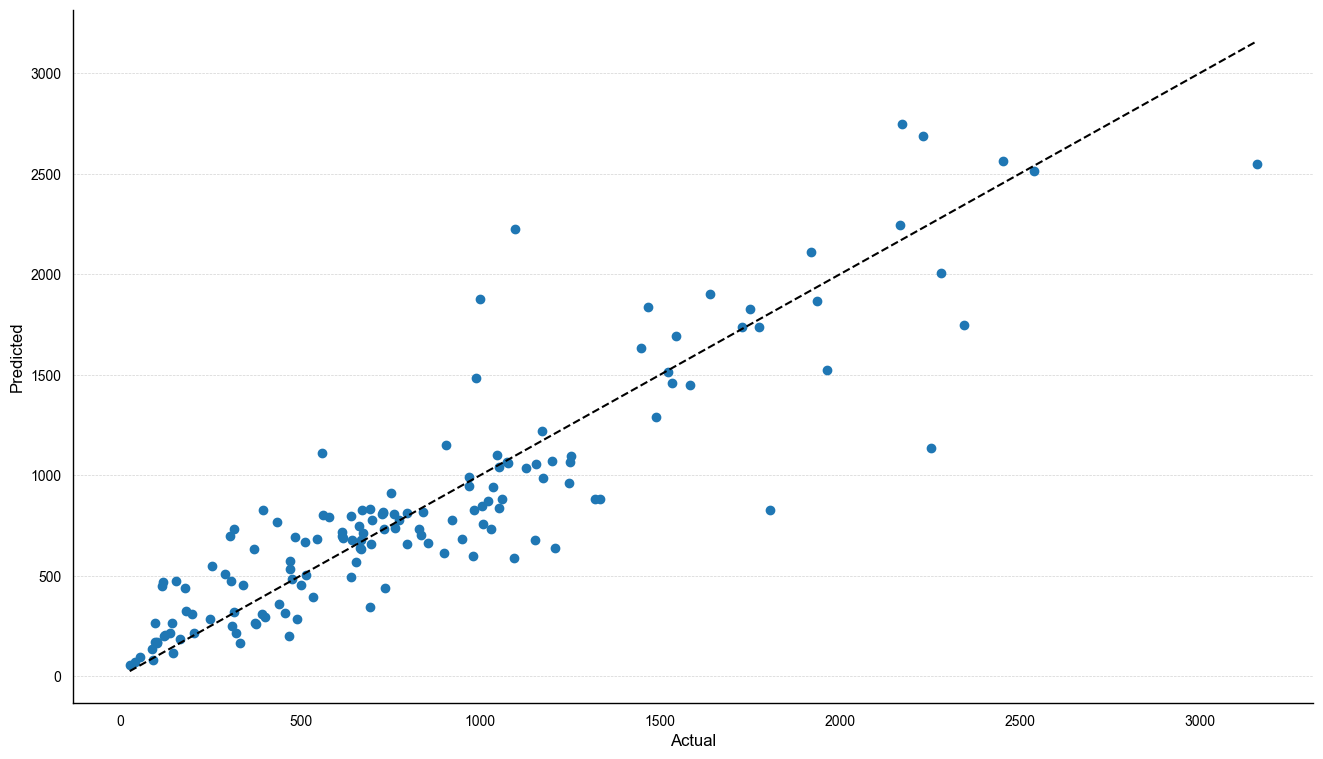

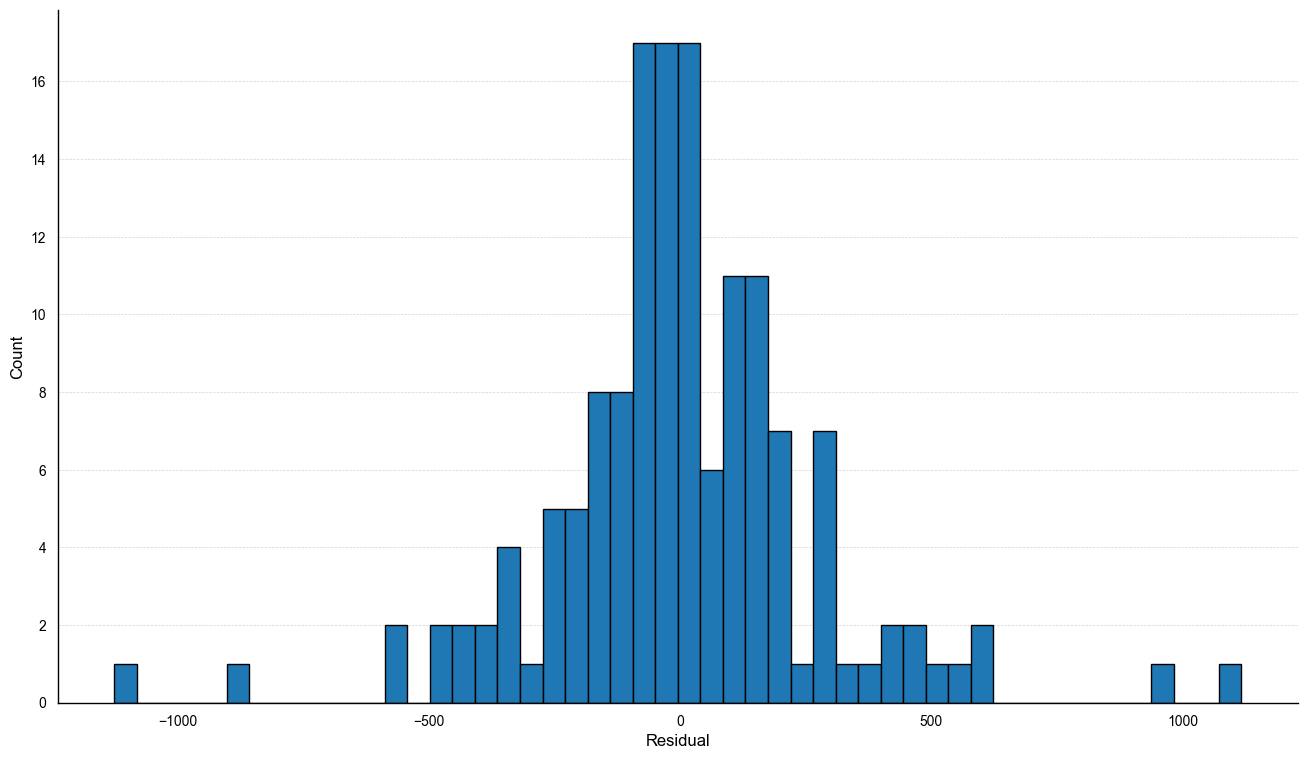

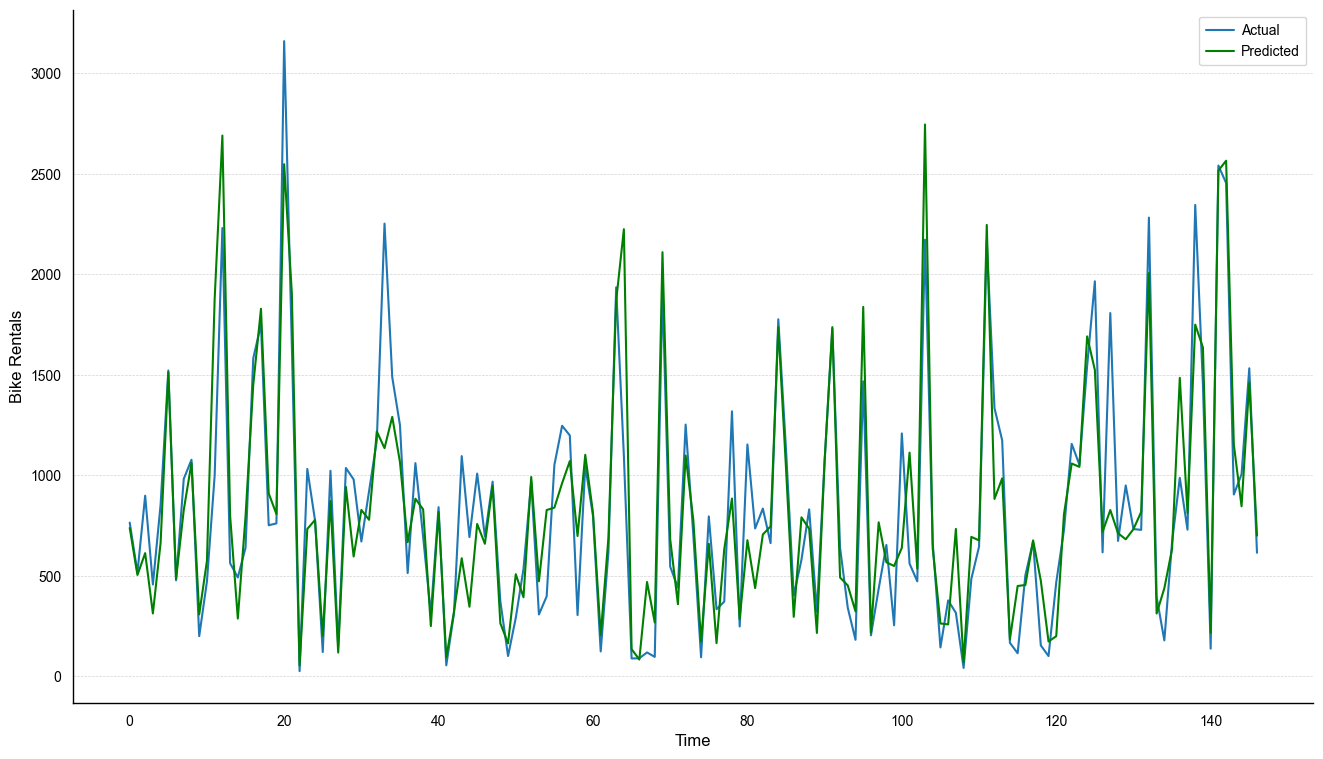

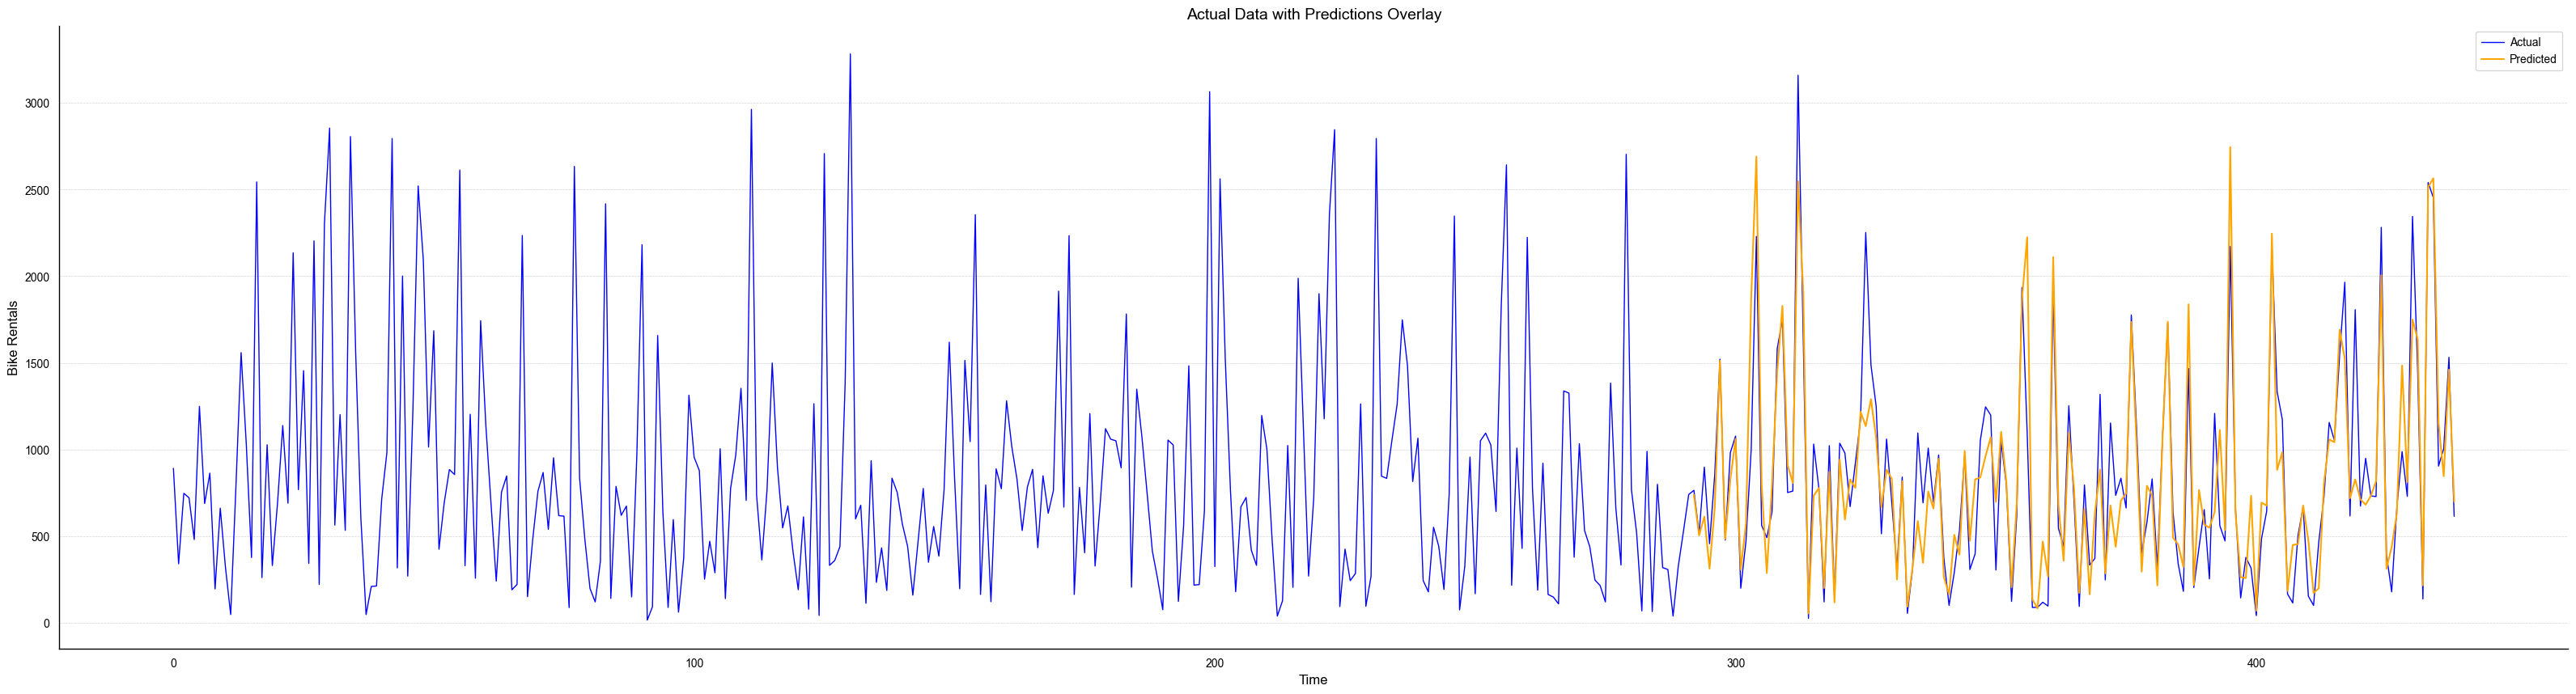

In [ ]:
figures = []  # List to store the figures

# Scatter plot of actual vs predicted
fig1, ax1 = plt.subplots()
plt.scatter(y_test, y_pred)
min_val = min(min(y_test), min(y_pred))
max_val = max(max(y_test), max(y_pred))
plt.plot([min_val, max_val], [min_val, max_val], color="black", linestyle="--")
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.show()
figures.append((fig1, "Scatter_plot_actual_vs_predicted.png"))

# Histogram of Residual
fig2, ax2 = plt.subplots()
residuals = y_test - y_pred
plt.hist(residuals, bins=50)
plt.xlabel("Residual")
plt.ylabel("Count")
plt.show()
figures.append((fig2, "Histogram_Residual.png"))

# Line plot of actual vs predicted over time
fig3, ax2 = plt.subplots()
plt.plot(y_test.values, label="Actual")
plt.plot(y_pred, label="Predicted", color="green")
plt.xlabel("Time")
plt.ylabel("Bike Rentals")
plt.legend()
plt.show()
figures.append((fig3, "Line_plot_actual_vs_predicted.png"))

# Show only the first 50% of y_train
train_size = len(y_train) // 2

# Combine first 50% of actuals from y_train and full y_test, with predictions overlay
y_full = pd.concat([y_train[:train_size], y_test])
y_pred_full = pd.concat(
    [pd.Series([np.nan] * train_size), pd.Series(y_pred, index=y_test.index)]
)

# Adjust figure size, line width, and x-axis ticks for better clarity
fig4, ax4 = plt.subplots(
    figsize=(40, 10)
)  # Increase figure size for better readability
plt.plot(y_full.values, label="Actual", color="blue", linewidth=1)  # Thicker lines
plt.plot(
    y_pred_full.values, label="Predicted", color="orange", linewidth=1.5
)  # Thicker lines
plt.xlabel("Time")
plt.ylabel("Bike Rentals")
plt.title("Actual Data with Predictions Overlay")
plt.legend()
plt.show()
figures.append((fig4, "Line_plot_full_actual_vs_predicted.png"))

In [ ]:
script_dir = os.path.dirname(__file__)
export_dir: str = os.path.join(script_dir, "../reports/figures/")

for index, (fig, filename) in enumerate(figures, start=1):
    export_figs(export_dir, fig, index, filename)

model_path = os.path.join(script_dir, "../models/bike-share.joblib")
dump(best_model, model_path)
print(f"Model saved at {model_path}")

Model saved at d:\Admin Files\Desktop\Data Proj\personal-proj\bike-rental-proj\src\../models/bike-share.joblib
